# Исследование рынка заведений общественного питания в Москве

## Содержание

### [Обзор данных](#overview)

### [Предобработка данных](#processing)

[Переименование колонки `'number'`](#number)

[Замена значений в колонке `'chain'`](#chain)

[Поиск дубликатов](#dublicates)

### [Исследовательский анализ данных](#research)

[Анализ видов заведений](#type)

[Анализ количества посадочных мест по видам заведений](#count_type)

[Анализ количества посадочных мест для сетевых заведений](#count_chain)

[Анализ заведений по улицам и районам](#street)

### [Общий вывод](#summary)

---

**Краткое описание:** Заказчик - партнеры и инвесторы проекта по открытию кафе в Москве, в котором посетителей будут обслуживать роботы. Инвесторы хотели бы узнать положение дел на рынке общественного питания и перспективность открытия подобного заведения.
    
**Цель проекта:** Исследовать рынок общественного питания в Москве.

**План работы:**
1. выгрузить данные, осуществить первичный обзор;
2. переименовать колонки, привести наименования к "змеиному регистру", если необходимо;
2. определить, есть ли пропуски в данных; заполнить пропуски или удалить строки с пропусками;
3. измененить тип данных;
4. проверить данные на наличие явных и неявных дубликатов, исправить данные;
5. провести исследовательский анализ данных, найти закономерности;
6. сформировать вывод, полученный из результатов анализа.

**Презентация:** <https://disk.yandex.by/i/YdXmL60bYsSPBA> 

## Обзор данных
<a class='anchor' id='overview'></a>

In [1]:
# загружаем нужные библиотеки
import os
import pandas as pd
import re
import numpy as np
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
pth1 = 'rest_data.csv' # Путь для Colaboratory
pth2 = '/datasets/rest_data.csv' # Путь для Jupyter Notebook в Практикуме
pth3 = r'C:\Users\WANTNEON\Downloads\rest_data.csv' # Локальный путь
    
if os.path.exists(pth1):
    data = pd.read_csv(pth1)
    print('Данные загружены в Colaboratory')
elif os.path.exists(pth2):
    data = pd.read_csv(pth2)
    print('Данные загружены в Jupyter Notebook')
elif os.path.exists(pth3):
    data = pd.read_csv(pth3)
    print('Данные загружены локально')
else:
    print('Что-то пошло не так')  

Данные загружены в Colaboratory


Посмотрим на данные и их характеристики.

In [3]:
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [5]:
data.columns

Index(['id', 'object_name', 'chain', 'object_type', 'address', 'number'], dtype='object')

In [6]:
data.describe()

,id,number
count,15366.000000,15366.000000
mean,119720.066901,59.547182
std,73036.130732,74.736833
min,838.000000,0.000000
25%,28524.000000,12.000000
50%,144974.500000,40.000000
75%,184262.250000,80.000000
max,223439.000000,1700.000000


**Результаты первичного обзора данных**

* Все колонки соответствуют требуемому стилю написания. Поменяем наименование колонки `'number'` на `'number_of_seats'`, чтобы не забыть во время анализа, что за количество отображено в колонке;

* В данных нет пропусков;

* В колонке `'chain'` поменяем значения `да` и `нет` и изменим тип данных на `bool`, чтобы упростить анализ.

* В колонке с количество посадочных мест явно есть выбросы. Минимальное значение `0` может быть выбросом или может обозначать объекты без посадочных мест. Возможно, такое значение может соответствовать отдельному типу заведения. Максимальное значение `1700` увеличивает среднее почти в два раза по сравнению с медианным значением. 

## Предобработка данных
<a class='anchor' id='processing'></a>

### Переименование колонки `'number'`
<a class='anchor' id='number'></a>

Переименуем колонку `'number'` и проверим, все ли получилось.

In [7]:
data = data.rename(columns={'number' : 'number_of_seats'})

data.columns

Index(['id', 'object_name', 'chain', 'object_type', 'address',
       'number_of_seats'],
      dtype='object')

### Замена значений в колонке `'chain'`
<a class='anchor' id='chain'></a>

Сначала посмотрим, нет ли в колонке иных значений, помимо `да` и `нет`.

In [8]:
data['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

Иных значений нет. Теперь можно их переименовать и изменить тип данных в колонке на `bool`.

In [9]:
data['chain'] = (
    data['chain']
    .replace({'да' : '1', 'нет' : '0'})
    .astype('int')
    .astype('bool')
)

print(data['chain'].value_counts()) # проверяем, все ли получилось
print()
data.info()

False    12398
True      2968
Name: chain, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               15366 non-null  int64 
 1   object_name      15366 non-null  object
 2   chain            15366 non-null  bool  
 3   object_type      15366 non-null  object
 4   address          15366 non-null  object
 5   number_of_seats  15366 non-null  int64 
dtypes: bool(1), int64(2), object(3)
memory usage: 615.4+ KB


### Поиск дубликатов
<a class='anchor' id='dublicates'></a>

Посмотрим, есть ли полные дубликаты в таблице.

In [10]:
data.duplicated().sum()

0

Таких дубликатов нет. Посмотрим уникалные значения столбцов `'id'`, `'object_name'`, '`object_type'` и `'address'`.

In [11]:
data['id'].value_counts().sort_values(ascending=False).head()

151635    1
23056     1
21065     1
23670     1
24309     1
Name: id, dtype: int64

Каждому заведению соответствует одна строка.

In [12]:
data['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

Теперь мы знаем, что все заведения разделены на 9 категорий.

In [13]:
data['object_name'].value_counts().head(20)

Столовая                    267
Кафе                        236
Шаурма                      234
KFC                         155
Шоколадница                 142
Макдоналдс                  122
Бургер Кинг                 122
Домино'с Пицца               86
Теремок                      84
Крошка Картошка              82
Пекарня                      76
Милти                        65
Суши Wok                     61
Буфет                        59
СТОЛОВАЯ                     52
Папа Джонс                   50
Кофе с собой                 44
Школьно-базовая столовая     44
Чайхона №1                   42
КАФЕ                         41
Name: object_name, dtype: int64

Здесь есть дубликаты. Попробуем обработать дубликаты сетевых заведений, поскольку они не уникальны и потребуются для дальнейшего анализа.

In [14]:
# запишем значения с наименованиями в новую колонку, чтобы сохранить
# первоначальное название, а обрабатывать будем первоначальную колонку

data['object_name_original'] = data['object_name']

In [15]:
# приведем значения столбца к нижнему регистру

data.loc[data['chain'] == True, 'object_name'] = (
    data.loc[data['chain'] == True, 'object_name'].str.lower()
) 

In [16]:
# создадим и применим функцию, которая убирает лишние слова и символы

def drop_word(value):
    if '-' in value:
        value = value.replace('-', ' ')
    words = ['кафе ', 'ресторан ', 'кофейня ', 'пиццерия ', 'закусочная ',
             '«', '»']
    for w in words:
        if w in value:
            value = value.replace(w, '')
        else:
            value = value
    return value

data.loc[data['chain'] == True, 'object_name'] = (
    data.loc[data['chain'] == True, 'object_name'].apply(drop_word)
)

In [17]:
# создадим и применим функцию, которая приводит к одному названию некоторые сети

def rename(name):
    if 'сабвей' in name or 'subway' in name:
        return 'subway'
    elif 'старбакс' in name or 'starbucks' in name:
        return 'starbucks'
    elif 'караваев' in name:
        return 'братья караваевы'
    elif 'суши вок' in name or 'суши wok' in name:
        return 'суши wok'
    else:
        return name
        
data.loc[data['chain'] == True, 'object_name'] = (
    data.loc[data['chain'] == True, 'object_name'].apply(rename)
)

In [18]:
data['address'].value_counts().head(20) #посмотрим адреса

город Москва, Ходынский бульвар, дом 4                                       95
город Москва, Пресненская набережная, дом 2                                  63
город Москва, проспект Мира, дом 211, корпус 2                               60
город Москва, Кировоградская улица, дом 13А                                  53
город Москва, площадь Киевского Вокзала, дом 2                               48
город Москва, улица Земляной Вал, дом 33                                     46
город Москва, Мытная улица, дом 74                                           46
город Москва, улица Новый Арбат, дом 21                                      42
город Москва, улица Ленинская Слобода, дом 26                                41
город Москва, Ярцевская улица, дом 19                                        40
город Москва, Кутузовский проспект, дом 57                                   40
город Москва, поселение Сосенское, Калужское шоссе, 22-й километр, дом 10    38
город Москва, Нижняя Красносельская улиц

В одном здании по адресу Ходынский бульвар, дом 4 находится 95 заведений. Оказывается, что там расположен крупнейший в Европе по общей площади торгово-развлекательный центр "Авиапарк". То же самое и с остальными массовыми адресами: там расположены бизнес-центры, торговые дома и другие общественные здания.

В анализе нам понадобятся наименования улиц, поэтому создадим для этого новую колонку.

In [19]:
# создаем пустой список, в который запишем наименование улиц,
# если строка начинается с "город Москва";
# преобразуем результат в новую колонку

streets = []

for addr in data['address']:
    streets.append(''.join(re.findall(
        'город Москва, ([№"\w -]+), ', str(addr))))
    
data['street'] = pd.Series(streets)

In [20]:
# создаем такой же список, если строка начинается сразу с наименования улицы;
# преобразуем результат в новую колонку

streets_2 = []

for addr in data['address']:
    streets_2.append(''.join(re.findall(
        '^([№"\w -]+), ', str(addr))))
    
data['street_2'] = pd.Series(streets_2)

In [21]:
# в колонке 'street' есть незаполненные строки, но они не отмечены как пропуски;
# они образовались из-за того, что в колонке с адресами есть значения, не
# начинающиеся с "город Москва", но они есть в колонке 'street_2';
# заполним пустые значения колонки 'street' значениями из колонки 'street_2';
# удалим колонку 'street_2'

data['street'] = np.where(
    data['street'] == '',
    data['street_2'],
    data['street']
    )

data = data.drop(columns='street_2')

In [22]:
# создаем такой же пустой список, если строка отображает город Зеленоград;
# преобразуем результат в новую колонку

streets_zelen_1 = []
streets_zelen_2 = []

for addr in data['address']:
    streets_zelen_1.append(''.join(re.findall(
        'город Москва, город Зеленоград, ([№"\w -]+), ', str(addr))))
    
data['street_zelen_1'] = pd.Series(streets_zelen_1)

In [23]:
# в колонке 'street' уже заполнены значения городом Зеленоград;
# заменим эти значения колонки 'street' значениями из колонки 'street_zelen';
# удалим колонку 'street_zelen'

data['street'] = np.where(
    data['street'] == 'город Зеленоград',
    data['street_zelen_1'],
    data['street']
    )

data = data.drop(columns='street_zelen_1')

In [24]:
# в городе Зеленограде есть обозначения улиц, которые не заканчиваются запятой
# обработаем их отдельно

for addr in data['address']:
    streets_zelen_2.append(''.join(re.findall(
        'город Москва, город Зеленоград, ([№"\w -]+)', str(addr))))
    
data['street_zelen_2'] = pd.Series(streets_zelen_2)

In [25]:
data['street'] = np.where(
    data['street'] == '',
    data['street_zelen_2'],
    data['street']
    )

data = data.drop(columns='street_zelen_2')

In [26]:
# повторим то же самое для поселения Сосенское

streets_sosen_1 = []

for addr in data['address']:
    streets_sosen_1.append(''.join(re.findall(
        'город Москва, поселение Сосенское, ([№"\w -]+), ', str(addr))))
    
data['street_sosen_1'] = pd.Series(streets_sosen_1)

In [27]:
data['street'] = np.where(
    data['street'] == 'поселение Сосенское',
    data['street_sosen_1'],
    data['street']
    )

data = data.drop(columns='street_sosen_1')

In [28]:
streets_sosen_2 = []

for addr in data['address']:
    streets_sosen_2.append(''.join(re.findall(
        'город Москва, поселение Сосенское, ([№"\w -]+)', str(addr))))
    
data['street_sosen_2'] = pd.Series(streets_sosen_2)

In [29]:
data['street'] = np.where(
    data['street'] == '',
    data['street_sosen_2'],
    data['street']
    )

data = data.drop(columns='street_sosen_2')

In [30]:
# создадим и применим функцию, которая убирает лишние слова и символы;
# так мы уберем неявные дубликаты

def drop_street(value):
    words = ['улица ', ' улица', 'проспект ', ' проспект', 'проезд ',
             ' проезд', 'переулок ', ' переулок', ' шоссе', 'шоссе ',
             'площадь ', ' площадь', 'бульвар ', ' бульвар']
    for w in words:
        if w in value:
            value = value.replace(w, '')
        else:
            value = value
    return value

data['street'] = data['street'].apply(drop_street)

In [31]:
# посмотрим, как теперь выглядит таблица
data.head()

,id,object_name,chain,object_type,address,number_of_seats,object_name_original,street
0,151635,СМЕТАНА,False,кафе,"город Москва, улица Егора Абакумова, дом 9",48,СМЕТАНА,Егора Абакумова
1,77874,Родник,False,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,Родник,Талалихина
2,24309,Кафе «Академия»,False,кафе,"город Москва, Абельмановская улица, дом 6",95,Кафе «Академия»,Абельмановская
3,21894,пиццетория,True,кафе,"город Москва, Абрамцевская улица, дом 1",40,ПИЦЦЕТОРИЯ,Абрамцевская
4,119365,Кафе «Вишневая метель»,False,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Кафе «Вишневая метель»,Абрамцевская


## Исследовательский анализ данных
<a class='anchor' id='research'></a>

### Анализ видов заведений
<a class='anchor' id='type'></a>

Ранее мы определили, что все заведения общественного питания разделены на 9 видов. Рассмотрим их количественное и процентное соотношение. Для этого сгруппируем данные по виду заведения и посчитаем количество заведении данного вида. Построим графики.

In [32]:
type = (
    data.groupby('object_type')
    .agg({'id' : 'count'})
    .reset_index()
    .rename(columns={'id' : 'count'})
    .sort_values(by='count', ascending=False)
)

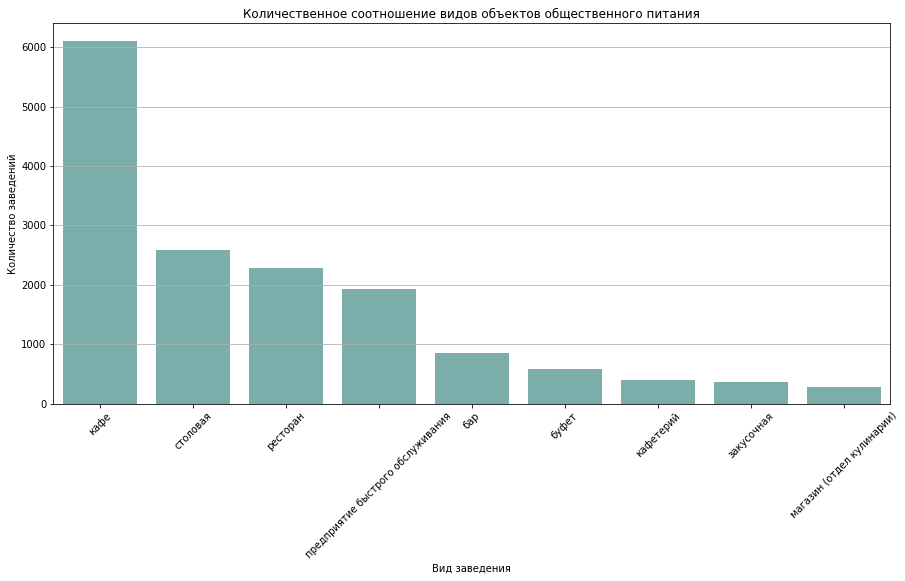

In [33]:
plt.figure(figsize=(15, 7))
plt.grid()

sns.barplot(x='object_type', y='count', data=type, color='#72B7B2') 

plt.xlabel('Вид заведения')
plt.xticks(rotation=45)
plt.ylabel('Количество заведений')
plt.title('Количественное соотношение видов объектов общественного питания')

plt.show()

In [34]:
fig = px.pie(
    type,
    values='count',
    names='object_type',
    title='Процентное соотношение видов объектов общественного питания',
    color_discrete_sequence=px.colors.qualitative.T10
    )

fig.show()

**Вывод**

На графиках видно, что почти 40% заведений - это кафе. Далее можно выделить группу с занимаемой долей в 12.5% - 16.8%: предприятия быстрого обслуживания, рестораны и столовые (по мере увеличения занимаемого процента). Третья группа с процентом менее 6: бары, буфеты, кафетерии, закусочные и отделы кулинарии в магазинах.

Теперь посмотрим на соотношение сетевых и не сетевых заведений. Для этого так же сформируем датасет и построим график.

In [35]:
chain = (
    data.groupby('chain')
    .agg({'id' : 'count'})
    .reset_index()
    .rename(columns={'id' : 'count'})
)

In [36]:
fig = px.pie(
    chain,
    values='count',
    names='chain',
    title='Процентное соотношение сетевых и несетевых объектов общественного питания'
    )

fig.update_traces(marker=dict(colors=['#B279A2', '#FF9DA6']))

fig.show()

**Вывод**

На круговой диаграмме видно, что 80.7% заведений не относятся к сетевым. Это означает, что как бы нам не казалось, что McDonald's захватил наши улицы, на самом деле это не так. Абсолютное большинство заведений уникальны и не развивается как сеть.

Чтобы определить, для какого вида заведения характерно сетевое распространение, создадим сводную таблицу, в которой посчитаем количество сетевых и несетевых заведений для каждого вида. Построим график.

In [37]:
chain_type = data.pivot_table(
    index='object_type',
    columns='chain',
    values='id',
    aggfunc='count').sort_values(by=False, ascending=False)

In [38]:
fig = px.bar(
    chain_type,
    x=chain_type.index,
    y=[False, True],
    title='Распределение сетевых заведений общественного питания по видам',
    labels=dict(
        value='Количество заведений',
        object_type='Вид заведения',
        variable='Признак сети'
    ),
    color_discrete_sequence=px.colors.qualitative.T10
)

fig.update_xaxes(tickangle=-45)
fig.show() 

Среди всех видов заведений только у столовых отсутствует какое-либо сетевое развитие. Особо выделяются кафе, рестораны и фастфуд. Посмотрим более детально на доли сетевых ресторанов для всех видов объектов общественного питания, построив круговые диаграммы.

In [39]:
chain_type_2 = data.pivot_table(
    index='chain',
    columns='object_type',
    values='id',
    aggfunc='count')

In [40]:
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Кафе', 'Столовая', 'Ресторан'),
                    specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(values=chain_type_2['кафе'], labels=chain_type_2.index),
    row=1, col=1
)

fig.add_trace(
    go.Pie(values=chain_type_2['столовая'], labels=chain_type_2.index),
    row=1, col=2
)

fig.add_trace(
    go.Pie(values=chain_type_2['ресторан'],
           labels=chain_type_2.index),
    row=1, col=3
)

fig.update_traces(marker=dict(colors=['#54A24B', '#EECA3B']))

fig.update_layout(
    title_text='Распределение сетевых заведений общественного питания по видам'
    )

fig.show()

In [41]:
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Фастфуд', 'Бар', 'Буфет'),
                    specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(values=chain_type_2['предприятие быстрого обслуживания'],
           labels=chain_type_2.index),
    row=1, col=1
)

fig.add_trace(
    go.Pie(values=chain_type_2['бар'], labels=chain_type_2.index),
    row=1, col=2
)

fig.add_trace(
    go.Pie(values=chain_type_2['буфет'],
           labels=chain_type_2.index),
    row=1, col=3
)

fig.update_traces(marker=dict(colors=['#9D755D', '#72B7B2']))

fig.update_layout(
    title_text='Распределение сетевых заведений общественного питания по видам'
    )

fig.show()

In [42]:
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=('Кафетерий', 'Закусочная', 'Кулинария'),
                    specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]])

fig.add_trace(
    go.Pie(values=chain_type_2['кафетерий'],
           labels=chain_type_2.index),
    row=1, col=1
)

fig.add_trace(
    go.Pie(values=chain_type_2['закусочная'], labels=chain_type_2.index),
    row=1, col=2
)

fig.add_trace(
    go.Pie(values=chain_type_2['магазин (отдел кулинарии)'],
           labels=chain_type_2.index),
    row=1, col=3
)

fig.update_traces(marker=dict(colors=['#E45756', '#BAB0AC']))

fig.update_layout(
    title_text='Распределение сетевых заведений общественного питания по видам'
    )

fig.show()

**Вывод**

Примерно одинаковая доля сетевых заведений у кафе и ресторанов: 22.9% и 23.8% соответственно. У фастфуда сети занимают 41.1% рынка. Можно сказать, что сегмент фастфуда более удачно развивается как сетевые заведения в отличие от других видов объектов общественного питания.

У отделов кулинарии доля сетевых заведений составляет 28.6%, однако это связано с большим количество магазинов, принадлежавших крупным сетям ритейла.

### Анализ количества посадочных мест по видам заведений
<a class='anchor' id='count_type'></a>

Теперь исследуем среднее количество посадочных мест для каждого вида заведения общественного питания.

Для начала посмотрим на выбросы.

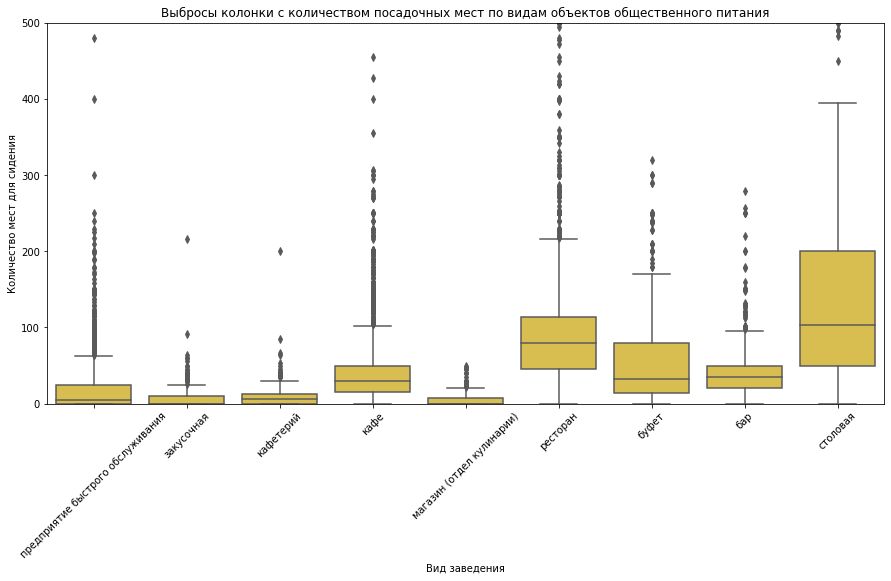

In [43]:
plt.figure(figsize=(15, 7))

sns.boxplot(
    x='object_type',
    y='number_of_seats',
    data=data.sort_values(by='number_of_seats'),
    color='#EECA3B'
    ) 

plt.xlabel('Вид заведения')
plt.ylabel('Количество мест для сидения')
plt.title('Выбросы колонки с количеством посадочных мест по видам объектов общественного питания')
plt.xticks(rotation=45)
plt.ylim(0, 500)

plt.show()

Уже с помощью этого графика можно увидеть, что у столовых наибольшее количество посадочных мест, а у отделов кулинарии в магазинах - наименьшее. Из-за того, что выбросов достаточно много, создадим сводную таблицу, которая будет считать не только среднее количество посадочных мест, но и медианное. График будем строить по медианным значениям.

In [44]:
data_type_gr = data.pivot_table(
    index = 'object_type',
    values = 'number_of_seats',
    aggfunc=['mean', 'median']
    ).reset_index()    

data_type_gr.columns = data_type_gr.columns.droplevel(1)

data_type_gr = (
    data_type_gr.astype({'mean' : 'int', 'median' : 'int'})
    .sort_values(by='median', ascending=False)
)

In [45]:
data_type_gr

,object_type,mean,median
8,столовая,130,103
7,ресторан,96,80
0,бар,43,35
1,буфет,51,32
3,кафе,39,30
4,кафетерий,9,6
6,предприятие быстрого обслуживания,20,5
2,закусочная,7,0
5,магазин (отдел кулинарии),5,0


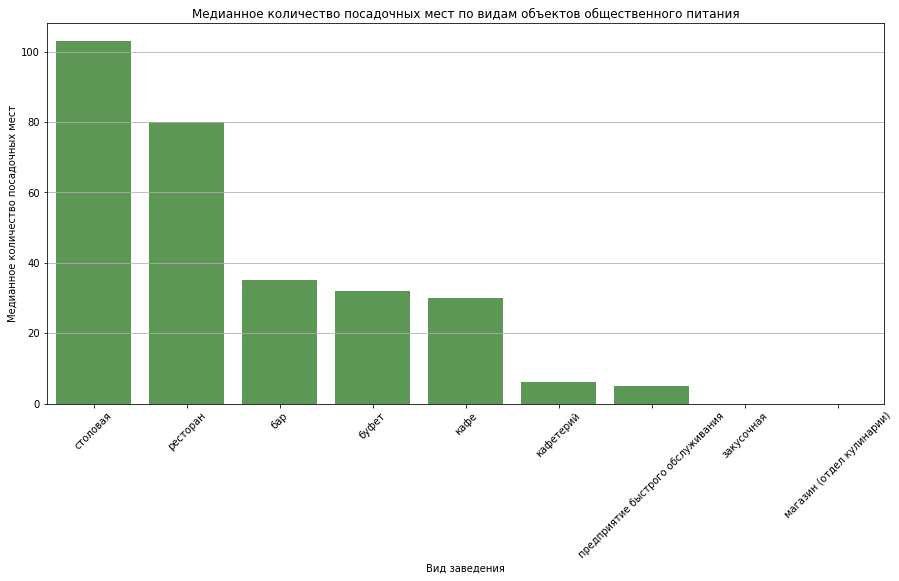

In [46]:
plt.figure(figsize=(15, 7))
plt.grid()

sns.barplot(x='object_type', y='median', data=data_type_gr, color='#54A24B') 

plt.xlabel('Вид заведения')
plt.xticks(rotation=45)
plt.ylabel('Медианное количество посадочных мест')
plt.title('Медианное количество посадочных мест по видам объектов общественного питания')


plt.show()

**Вывод**

Все виды заведений общественного питания можно разделить на 4 группы в зависимости от количества посдочных мест:
    
    
1. закусочные и отделы кулинарии в мазинах - для них не характерно наличие посадочных мест (предположение о том, что отсутствие посадочных мест характерно для конкретных видов заведений, подтвердилось);
    
    
2. заведения фастфуда и кафетерии - 5 и 6 посадочных мест соответственно;
    
    
3. кафе, буфеты и бары - 30-35 посадочных мест;
    
    
4. рестораны и столовые - 80 и 103 посадочных места соответсвенно.

### Анализ количества посадочных мест для сетевых заведений
<a class='anchor' id='count_chain'></a>

Теперь попробуем определить, что характерно для сетей: большое количество заведений с малым количеством посадочных мест или, наоборот, малое количество заведений с большим количеством посадочных мест.

Сначала посмотрим на общее распределение посадочных мест.

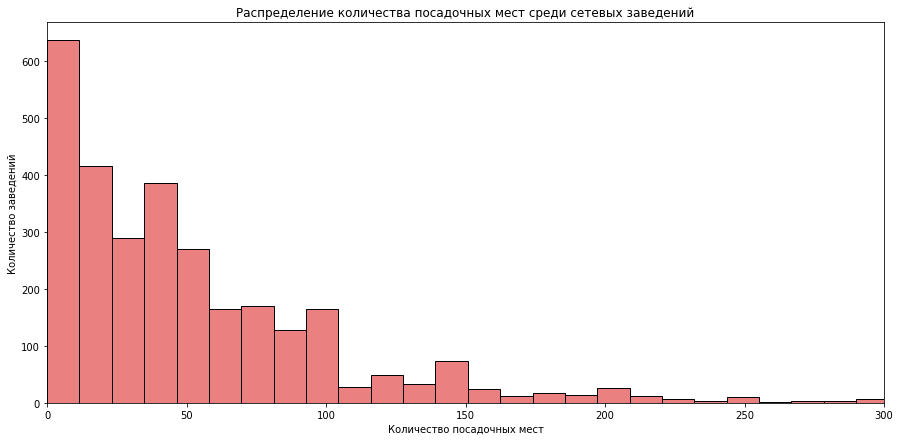

In [47]:
plt.figure(figsize=(15, 7))

sns.histplot(
    data.loc[data['chain'] == True, 'number_of_seats'],
    bins=50,
    color='#E45756'
    ) 

plt.xlim([0, 300])
plt.xlabel('Количество посадочных мест')
plt.ylabel('Количество заведений')
plt.title('Распределение количества посадочных мест среди сетевых заведений')

plt.show()

Наибольшее количество заведений, принадлежащих к какой-либо из сетей, имеет до 12 посадочных мест. В целом, явно выделяются три группы: до 60 мест, до 108 мест и более 108 мест. Их можно определить как малое количество мест, среднее количество мест и большое количество мест.

Теперь посчитаем количество заведений и медианное количество посадочных мест для каждой сети, т.к. помним про выбросы, искажающее среднее. Построим точечный график.

In [48]:
# определяем названия сетевых заведений, повторяющихся два и более раза,
# чтобы исключить единичные случаи, которые не получилось обработать
# при устранении неявных дубликотов

cafe_names = (
    data.loc[data['chain'] == True, 'object_name']
    .value_counts()
    .loc[lambda x : x > 1]
)

In [49]:
# создаем датасет с нужным срезом данных
data_chain = data.query('object_name in @cafe_names.index').copy()

In [50]:
# группируем данные

data_chain_gr = (
    data_chain.groupby('object_name')
    .agg({'id' : 'count', 'number_of_seats' : 'median'})
    .rename(columns={'id' : 'count_of_cafes'})
)

data_chain_gr['number_of_seats'] = (
    data_chain_gr['number_of_seats'].astype('int')
)

In [51]:
data_chain_gr.sort_values(by='count_of_cafes', ascending=False).head(10)

,count_of_cafes,number_of_seats
object_name,,
шоколадница,183,50
kfc,173,48
макдоналдс,165,79
бургер кинг,147,45
теремок,106,23
домино'с пицца,97,16
крошка картошка,93,15
суши wok,90,6
милти,72,0


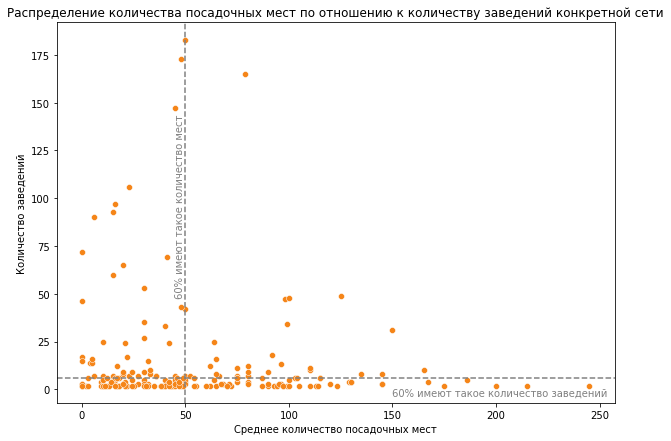

In [52]:
# определяем значение 60 процентиля для медианного количества сидений
# и количество заведений конкретной сети;
# так мы отобразим абсолютное большинство

seats_60 = np.percentile(data_chain_gr['number_of_seats'], 60)
cafes_60 = np.percentile(data_chain_gr['count_of_cafes'], 60)

# строим график

plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=data_chain_gr,
    x='number_of_seats',
    y='count_of_cafes',
    color='#F58518')

# добавляем линию 60 процентили количества заведений

plt.axhline(
    cafes_60,
    linestyle='--',
    color='grey'
    )

# добавляем ее подпись

plt.text(
    seats_60 + 100,
    cafes_60 - 5,
    '60% имеют такое количество заведений',
    color='grey',
    va='top',
    fontsize=10
    )

# добавляем линию 60 процентили количества сидений

plt.axvline(
    seats_60,
    linestyle='--',
    color='grey'
    )

# добавляем ее подпись

plt.text(
    seats_60,
    cafes_60 + 42,
    '60% имеют такое количество мест',
    color='grey',
    ha='right',
    va='bottom',
    rotation='vertical',
    fontsize=10
    )

# добавляем подписи осей и заголовок

plt.xlabel('Среднее количество посадочных мест')
plt.ylabel('Количество заведений')
plt.title('Распределение количества посадочных мест по отношению к количеству заведений конкретной сети')

plt.show()

**Вывод**

На графике отчетливо видно, что сети редко развиваются в более чем 10 заведений. При этом наибольшее число из таких заведений имеет не более 50 пасадочных мест.

Это характерно и для сетей, которые развились и в более чем 50 заведений. Если посмотреть на сводную таблицу, то можно увидеть, что среди десяти самых массовых сетей количество посадочных мест не превышает отметку в 50, кроме McDonald's: у него 79 мест.

Можно увидеть следующую тенденцию: чем больше среднее количество посадочных мест у заведений сети, тем реже сеть превышает отметку в 10-15 заведений.

Таким образом, можно сделать вывод, что для сетей характерно большое количество заведений с небольшим количеством посадочных мест. 

Интересно отметить, что малое количество мест характерно для сетевых заведений с большим количеством заведений, но так сказать про все заведения нельзя. Например, столовые и рестораны более распространены, чем предприятия быстрого обслуживания, при этом среднее количество мест в них в разы больше.

### Анализ заведений по улицам и районам
<a class='anchor' id='street'></a>

Посмотрим, на каких улицах больше всего объектов общественного питания. Для этого сгруппируем данные, выберем топ-10 и построим график.

In [53]:
street_gr = (
    data.groupby('street')
    .agg({'id' : 'count'})
    .sort_values(by='id', ascending=False)
)

street_gr_top = street_gr.head(10)

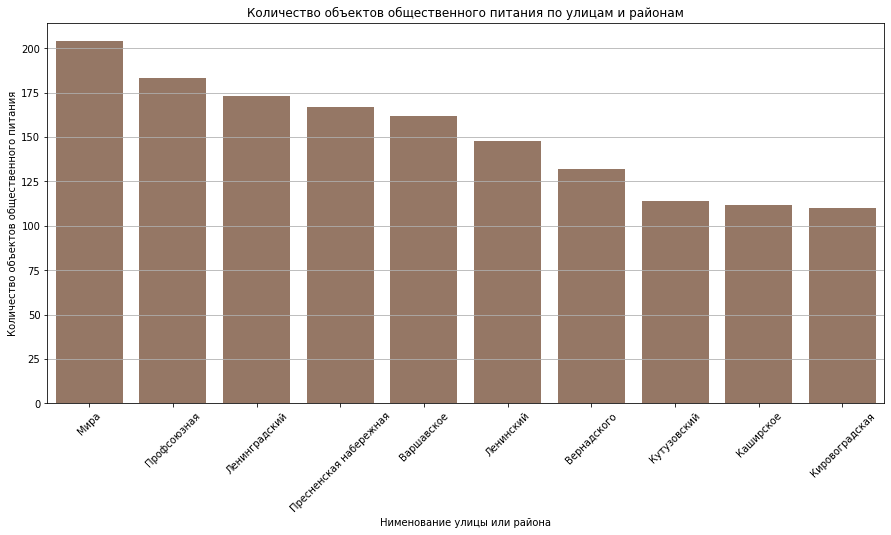

In [54]:
plt.figure(figsize=(15, 7))
plt.grid()

sns.barplot(x=street_gr_top.index, y='id', data=street_gr_top, color='#9D755D') 

plt.xlabel('Нименование улицы или района')
plt.xticks(rotation=45)
plt.ylabel('Количество объектов общественного питания')
plt.title('Количество объектов общественного питания по улицам и районам')


plt.show()

Необходимо посмотреть, в каких районах и округах Москвы находятся объекты общепита. Загрузим необходимые данные с портала открытых данных Правительства Москвы и присоединим необходимые колонки к копии основной таблицы, т.к. одна улица может находиться в нескольких районах, а это удваивает / утраивает количество строк для одного заведения.

In [55]:
spreadsheet_id = '1opX4O8AfO84UWyvTVZM8MgUbFeuTTnx2DWH2L0z1Kkk'

file_name = (
    'https://docs.google.com/spreadsheets/d/{}/export?format=csv'
    .format(spreadsheet_id)
)

r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df.columns = df.columns.str.lower()

In [56]:
data_copy = data.merge(
    df[['address', 'admarea', 'district']],
    how='left',
    left_on='address',
    right_on='address'
    )

In [57]:
print('Количество строк в таблице:', len(data_copy))

print('Количество пропусков в колонке district:',
      data_copy['district'].isna().sum())

print('Процент пропусков в колонке district:',
      round(data_copy['district'].isna().sum() / len(data_copy) * 100, 2), '%')

Количество строк в таблице: 16916
Количество пропусков в колонке district: 12932
Процент пропусков в колонке district: 76.45 %


Пропусков получилось много. Поскольку в процессе осуществления исследования доступ к порталу открытых данных Правительства Москвы отсутствовал, то будем работать с тем, что есть. Обращаем внимание, что из-за этого количество заведений по районам и округам будет меньше, чем по улицам. Таблицы с районами выводятся для понимания расположения улиц. В то же время, район для некоторых улиц не будет определен. 

In [58]:
# отобразим сводную таблицу, в которой для каждой улицы из топ-10 будет указан
# административные округа и районы, которые пересекает улица;
# отсортируем таблицу в алфавитном порядке наименования улиц;

(
    data_copy.query('street in @street_gr_top.index')
    .pivot_table(
        index=['street', 'admarea', 'district'],
        values='id',
        aggfunc='count')
    .sort_values(by='street')
)

id
street         admarea                                 district                           
Варшавское     Южный административный округ            Донской район                     4
                                                       Нагорный район                    6
                                                       район Чертаново Северное          8
                                                       район Чертаново Центральное       1
                                                       район Чертаново Южное             6
Вернадского    Западный административный округ         район Тропарёво-Никулино          3
Каширское      Южный административный округ            район Москворечье-Сабурово       36
                                                       район Нагатино-Садовники          4
                                                       район Орехово-Борисово Северное   6
Кировоградская Южный административный округ            район Чертаново Северное         29
                                                       район Чертаново Центральное       6
Кутузовский    Западный административный округ         район Фили-Давыдково              2
                                                       район Дорогомилово               54
Ленинградский  Северный административный округ         район Аэропорт                   42
                                                       район Беговой                    28
Мира           Северо-Восточный административный округ Алексеевский район                3
                                                       Останкинский район               12
               Центральный административный округ      Мещанский район                   4
Профсоюзная    Юго-Западный административный округ     Академический район              13
                                                       Обручевский район                 1
                                                       район Коньково                    4
                                                       район Тёплый Стан                 1
                                                       район Черёмушки                  31

Разберем каждую улицу и район.
1. **Проспект Мира** примыкает к центру Москвы. На нем расположены Рижский вокзал и ВДНХ, вдоль проспекта проходит Калужско-Рижская линия метро. **204 объекта**;
2. **Профсоюзная улица** также примыкает к центру и вдоль нее проходит Калужско-Рижская линия метро. Улица расположена параллельно проспекту Вернадского и Ленинской улице. **183 объекта**;
3. **Ленинградский проспект** примыкает к центру Москвы. В начале проспекта расположен Белорусский вокзал, а вдоль него проходит Замоскворецкая линия метро. **173 объекта**;
4. **Пресненская набережная** - небольшая улица вдоль Москвы-реки, с одной стороны, и Москва-Сити с другой. Рядом проходят линии метро Филёвская и Московское центральное кольцо. **167 объектов**;
5. **Варшавское шоссе** - магистральная улица, проходящая от Большой Тульской улицы до южной границы города. Протяженность 22.5 км. **162 объекта**;
6. **Ленинский проспект** начинается от центральной части Москвы и расположена параллельно проспекту Вернадского и Профсоюзной улице. **148 объектов**;
7. **Проспект Вернадского** начинается от Воробьевых гор и расположен параллено Профсоюзной улице и Ленинскому проспекту. Вдоль проспекта проходит Сокольничская линия метро. Также проспет пересекают Университетский и Ломоносовский проспекты, между которыми расположено МГУ. **132 объекта**;
8. **Кутузовский проспект** начинается от Абрата и располагается параллельно Пресненской набережной. На проспекте находится Поклонная гора, а вдоль него проходит Арбатско-Покровская линия метро. **114 объектов**;
9. **Каширское шоссе** ответвляется от Варшавского шоссе на границе районов Нагатино-Садовники и Нагорный и заканчивается МКАДом. Вдоль шоссе расположены парковые зоны. Шоссе дважды пересекает замоскворецкую линию метро на станциях Каширская и Домодедовская. **112 объектов**;
10. **Кировоградская улица** проходит вдоль Серпуховско-Тимирязевской линии метро, параллельная Варшавскому шоссе и пересекающая всё Чертаново. Улица имеет не большую протяженность в 4.2 км, но на най располагается сразу два торговых центра. **110 объектов**;

**Вывод**

Таким образом, наибольшее количество заведений располагается:
    
    
* на пересечении Центрального и Северо-Восточного административных округов и сам Северо-восточный округ, вдоль которого проходит проспект Мира;
    
    
* на пересечении Юго-Западно и Западного административных округов Москвы, т.к. здесь расположены Профсоюзная улица, Ленинский проспект и проспект Вернадского;
    
    
* в Северном административном округе, где находится Ленинградский проспект;
    
    
* на пересечении Западного и Центрального админитративных округов, т. к. там находятся Кутузовский проспект и Пресненская набережная;
    
    
* на пересечении Центрального и Южного административных округов и сам Южный округ, вдоль которых проходят Кировоградская улица, Каширское шоссе, а также Варшавское шоссе, которое продолжается в Подольске и далее в юго-западном направлении.

Посмотрим на улицы, где находится только одно заведение общественного питания.

In [59]:
street_gr.query('id == 1').count() # посчитаем их количество

id    631
dtype: int64

In [60]:
# посмотрим на 20 из них

data_copy.pivot_table(
    index=['street', 'admarea', 'district'],
    values='id',
    aggfunc='count'
    ).query('id == 1').tail(20)

,,,id
street,admarea,district,
Сретенский тупик,Центральный административный округ,Красносельский район,1
Столовый,Центральный административный округ,Пресненский район,1
Стрелецкая,Северо-Восточный административный округ,район Марьина Роща,1
Таможенный,Юго-Восточный административный округ,район Лефортово,1
Татарская,Центральный административный округ,район Замоскворечье,1
Ткацкая,Восточный административный округ,район Соколиная Гора,1
Троилинский,Центральный административный округ,район Арбат,1
Трубниковский,Центральный административный округ,район Арбат,1
Фадеева,Центральный административный округ,Тверской район,1


**Вывод**

В таблице отмечено 633 улицы Москвы, на которых расположен только один объект. Основная характеристика таких улиц, что они не длинные либо это не улицы, а переулки.

Можно выделить две группы по расположению таких улиц:

1. Улицы, расположеные в спальных районах, жилищных комплексах за пределами Третьего транспортного кольца, где нет какого-либо торгового центра или зоны отдыха. Например, Химкинский бульвар, Широкая и Энергетическая улица.


2. Короткие улицы и переулки, которые находятся в самом центре Москвы. Например, 1-й и 5-й Монетчиковские переулки, которые находятся в самом центре Замоскворечья. В этом месте сконцентрировано большое количество исторических зданий, а протяженность переулков всего 1-2 дома. То же самое с Филипповским переулком, который находится в Арбате. Его протяженнсть больше, но здесь расположены другие общественные объекты.

Теперь посмотрим, какое количество посадочных мест характерно для каждой улицы из топ-10.

Для этого сгруппируем график, посчитаем медианное значение дя каждой улицы и построим график.

In [61]:
streets_top_gr = (
    data.query('street in @street_gr_top.index')
    .groupby('street')
    .agg({'number_of_seats' : 'median'})
    .sort_values(by='number_of_seats', ascending=False)
)

streets_top_gr['number_of_seats'] = (
    streets_top_gr['number_of_seats'].astype('int')
)

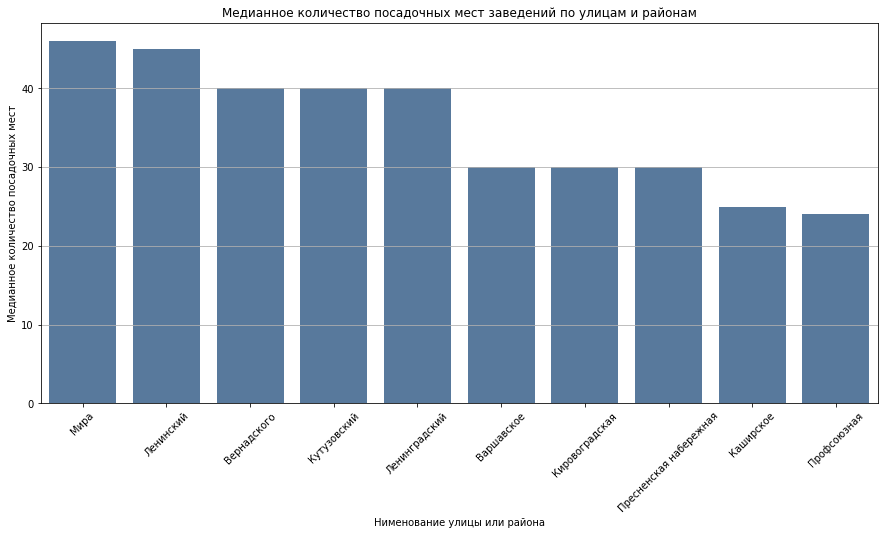

In [62]:
plt.figure(figsize=(15, 7))
plt.grid()

sns.barplot(
    x=streets_top_gr.index,
    y='number_of_seats',
    data=streets_top_gr,
    color='#4C78A8'
    ) 

plt.xlabel('Нименование улицы или района')
plt.xticks(rotation=45)
plt.ylabel('Медианное количество посадочных мест')
plt.title('Медианное количество посадочных мест заведений по улицам и районам')


plt.show()

На мой взгляд, нельзя рассматривать количество посадочных мест, не обращая внимание на виды заведений, которые расположены в этих районах, поскольку ранее было определено, что для определенных видов заведений характерно определенное количество посадочных мест.

Сгруппируем данные таким образом, чтобы посчитать количество заведений определенного ида для каждого района, пропуски заполним нулями. Построим график.

In [63]:
street_type = (
    data.query('street in @street_gr_top.index')
    .pivot_table(
        index='street',
        columns='object_type',
        values='id',
        aggfunc='count'
        ).fillna(0).astype('int')
)

In [64]:
fig = px.bar(
    street_type,
    x=street_type.index,
    y=['бар', 'буфет', 'закусочная', 'кафе', 'кафетерий',
       'магазин (отдел кулинарии)', 'предприятие быстрого обслуживания',
       'ресторан', 'столовая'],
    title='Количество объектов по видам заведений для топ-10 улиц Москвы',
    labels=dict(
        value='Количество заведений',
        street='Наименование улицы',
        variable='Вид заведения'
    ),
    color_discrete_sequence=px.colors.qualitative.T10
)

fig.update_xaxes(tickangle=-45)
fig.show() 

**Вывод**

    
* На графике видно, что медианное значение посадочных мест составляет 40-46 для всех проспектов. На таких широких улицах много помещений, где можно разместить заведение побольше. Здесь много ресторанов (как было определено ранее, в них больше посадочных мест) и кафе.

    
* Для Варшавского и Каширского шоссе характерны заведения с 30 и 25 посадочными местами соответственно. Это может быть связано с тем, что данные шоссе направлены на выезд из города и вне жилых районов, а для путешественников важнее быстро перекусить. Поэтому здесь распространены кафе и заведения фастфуда.

    
* У Пресненской набережной и Профсоюзной улицы примерно одинаковое распределение различных видов заведений, кроме столовых, которых на набережной нет: их заменяют рестораны. Наибольшая доля на данных улицах у кафе. Это может быть связано с тем, что в отличие от проспектов, набережная и улица узкие, меньше помещений, в которых можно открыть большое заведение. Медианное количество посадочных мест для Пресненской набережной - 30, а для Профсоюзной улицы - 24.

    
* Кировоградская улица отличается от предыдущих тем, что здесь большую долю занимают предприятия быстрого обслуживания. Это можно связаться с тем, что большинство расположенных здесь заведений находится в торговых центрах,где есть фудкорты. Медианное количество посдачных мест - 30.

## Общий вывод
<a class='anchor' id='summary'></a>

1. 40% заведений составляют кафе. Предприятия быстрого обслуживания, рестораны и столовые занимают 12.5%, 14.9% и 16.8% рынка соответственно. Бары, буфеты, кафетерии, закусочные и отделы кулинарии в магазинах в сумме занимают 16%.

---

2. Только 19.3% заведений относятся к какой-либо сети. У столовых полностью отсутствует сетевое развитие. Лучше всего в сеть развиваются заведения фастфуда (41% заведений представляют какую-либо сеть). Далее - кафе и рестораны (23% составляют сети).

---

3. Все виды заведений общественного питания можно разделить на 4 группы в зависимости от количества посадочных мест:
* закусочные и отделы кулинарии в магазинах - для них характерно отсутствие посадочных мест;
* заведения фастфуда и кафетерии - 5 и 6 посадочных мест соответственно;
* кафе, буфеты и бары - 30-35 посадочных мест;
* рестораны и столовые - 80 и 103 посадочных места соответственно.

---

4. Для сетей характерно большое количество заведений с небольшим количеством посадочных мест. Чем больше среднее количество посадочных мест у заведений сети, тем реже сеть превышает отметку в 10-15 заведений. Сети редко развиваются в более чем 10 заведений. При этом наибольшее число из таких заведений имеет не более 50 посадочных мест.

---

5. Наибольшее количество заведений располагается:
* на пересечении Центрального и Северо-Восточного административных округов и сам Северо-восточный округ;
* на пересечении Юго-Западно и Западного административных округов Москвы;
* в Северном административном округе;
* на пересечении Западного и Центрального админитративных округов;
* на пересечении Центрального и Южного административных округов и сам Южный округ.

---

6. Основные характеристики улиц, на которых расположено только одно заведений - они не длинные либо это не улицы, а переулки. Как правило, это улицы, расположеные в спальных районах, жилищных комплексах за пределами Третьего транспортного кольца, где нет какого-либо торгового центра или зоны отдыха. Либо это короткие улицы и переулки, которые находятся в самом центре Москвы. 

---

7. Для проспектов медианное значение посадочных мест составляет 40-45. Здесь много ресторанов и кафе.

  Для Варшавского и Каширского шоссе характерны заведения с 25-30 посадочными местами, т.к. данные шоссе направлены на выезд из города и вне жилых районов, а для путешественников важнее быстро перекусить. Здесь распространены кафе и заведения фастфуда.

  У Пресненской набережной и Профсоюзной улицы примерно одинаковое распределение различных видов заведений, кроме столовых, которых на набережной нет: их заменяют рестораны. Наибольшая доля на данных улицах у кафе. Медианное количество посадочных мест для Пресненской набережной - 30, а для Профсоюзной улицы - 24.

  На Кировоградской улице большую долю занимают предприятия быстрого обслуживания, поскольку большинство расположенных здесь заведений находится в торговых центрах, где есть фудкорты. Медианное количество посдачных мест - 30.

**Итог**

Самым распространенным видом заведения является кафе. Они хорошо развиваются в сеть и занимают большую долю заведений во всех популярных районах. Среднее количество посадочных мест для них - 30. 

Также, учитывая концепцию будущего заведния, можно обратить внимание на заведения фастфуда. Они лучше всего развиваются в сеть. Среднее количество посадочных мест - 5.

Наиболее подходящие районы для развития: Северный, Южный и Северо-Восточный округ, район пересечения Юго-Западного и Западного округов, район пересечения Западного и Центрального административных округов Москвы.